# Data description & Problem statement: 
   The dataset is related with a mortgage loan and challenge is to predict approval status of loan (Approved/Reject). Needless to mention that, among all industries, the insurance domain has one of the largest uses of analytics & data science methods. 
* Dataset is imbalanced. The data has 615 rows and 13 columns.
* This is a classification problem. I will predict if a loan will get approved or not.

# Workflow:
- Load the dataset, and define the required functions (e.g. for detecting the outliers)
- Data Cleaning/Wrangling: Manipulate outliers, missing data or duplicate values, Encode categorical variables, etc.
- Split data into training & test parts (utilize the training part for training & hyperparameter tuning of model, and test part for the final evaluation of model)
   #  Model Training:
- Build an initial SVM model, and evaluate it via C-V approach
- Use grid-search along with C-V approach to find the best hyperparameters of SVM model: Find the best SVM model (Note: I've utilized SMOTE technique via imblearn toolbox to synthetically over-sample the minority category and even the dataset imbalances.)
   # Model Evaluation: 
- Evaluate the best SVM model with optimized hyperparameters on Test Dataset, by calculating:
     - AUC score:  0.87
     - Confusion matrix
     - ROC curve  
     - Precision-Recall curve 
     - Average precision:  0.92

In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
%matplotlib inline

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Function to remove outliers (all rows) by Z-score: 
def remove_outliers(X, y, name, thresh=3):
    L=[]
    for name in name:
        drop_rows = X.index[(np.abs(X[name] - X[name].mean()) >= (thresh * X[name].std()))]
        L.extend(list(drop_rows))
        
    X.drop(np.array(list(set(L))), axis=0, inplace=True)
    y.drop(np.array(list(set(L))), axis=0, inplace=True)
    print('number of outliers removed :  ' , len(L))

In [3]:
df=pd.read_csv('C:/Users/rhash/Documents/Datasets/Loan prediction/train_loanPrediction.csv')

# To Shuffle the data:
np.random.seed(42)
df=df.reindex(np.random.permutation(df.index))
df.reset_index(inplace=True, drop=True)
df.drop('Loan_ID', axis=1, inplace=True)

L_c=['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area', 'Loan_Status' ]
L_n=['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

df.head(3)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,Yes,0,Graduate,No,9083,0.0,228.0,360.0,1.0,Semiurban,Y
1,Male,Yes,0,Graduate,No,4310,0.0,130.0,360.0,NaN,Semiurban,Y
2,Male,Yes,2,Graduate,No,4167,1447.0,158.0,360.0,1.0,Rural,Y


In [4]:
df_selected=df[['Credit_History', 'ApplicantIncome', 'LoanAmount', 'CoapplicantIncome' , 'Property_Area', 'Loan_Status']]

#df_selected['LoanAmount'].fillna(value=df['LoanAmount'].mean(), inplace=True)

df_selected.dropna( axis=0, inplace=True)

df_selected.shape

(543, 6)

In [5]:
# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

for i in [ 'Property_Area', 'Loan_Status' ]:
    encode_text_index(df_selected, i)
    
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

#for i in ['Credit_History' , 'Property_Area']:
#   encode_text_dummy(df_selected, i)

    
df_selected.head(3)

,Credit_History,ApplicantIncome,LoanAmount,CoapplicantIncome,Property_Area,Loan_Status
0,1.0,9083,228.0,0.0,1,1
2,1.0,4167,158.0,1447.0,0,1
3,1.0,2900,71.0,0.0,0,1


In [6]:
X=df_selected.drop(['Loan_Status'], axis=1)
y=df_selected['Loan_Status']

# We initially devide data into training & test folds: We do the Grid-Search only on training part  
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

remove_outliers(X_train, y_train, ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount'], thresh=5)

number of outliers removed :   8


In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

scalor_X=MinMaxScaler().fit(X_train)
X_train=scalor_X.transform(X_train)
X_test=scalor_X.transform(X_test)

In [8]:
# We build the Initial Model & Cross-Validation:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

model=SVC(random_state=42)
kfold=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores=cross_val_score(model, X_train, y_train, cv=kfold, scoring="roc_auc")

print(scores, "\n")
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))

[0.67785714 0.83345455 0.76509091 0.79636364 0.73939394] 

Accuracy: 0.76 (+/- 0.05)


In [16]:
# Grid-Serach for the best model parameters: 

# Rough Search (Round 1)
from sklearn.model_selection import GridSearchCV

param={'kernel':['rbf'], 'C': [0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 1, 5, 10, 50, 100, 300, 500, 700, 1000, 1e4], 
                         'gamma':[0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 50, 100, 1000, 1e4 ]}

kfold=StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
grid_search=GridSearchCV(SVC(class_weight='balanced', probability=True), param, cv=kfold, scoring="roc_auc", n_jobs=-1)
grid_search.fit(X_train, y_train)

# Grid-Search report: 
G=pd.DataFrame(grid_search.cv_results_)
G.sort_values("rank_test_score").head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
109,0.037605,0.003938,0.002549,0.001706,5,0.05,rbf,"{'C': 5, 'gamma': 0.05, 'kernel': 'rbf'}",0.751753,0.748948,...,0.812062,0.782141,0.031833,1,0.811594,0.807958,0.790920,0.784894,0.798842,0.011214
138,0.045795,0.004564,0.003980,0.001918,50,0.01,rbf,"{'C': 50, 'gamma': 0.01, 'kernel': 'rbf'}",0.748013,0.760636,...,0.811594,0.780856,0.027068,2,0.809932,0.804010,0.784894,0.783544,0.795595,0.011577
95,0.048731,0.011897,0.011092,0.012079,1,0.1,rbf,"{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}",0.746143,0.739598,...,0.811594,0.780505,0.037988,3,0.808529,0.807179,0.786089,0.778609,0.795102,0.013033


In [17]:
print("Best parameters: ", grid_search.best_params_)
print("Best validation accuracy:  %0.2f (+/- %0.2f)" % (np.round(grid_search.best_score_, decimals=2), np.round(G.loc[grid_search.best_index_,"std_test_score" ], decimals=2)))
print("Test score: ", np.round(grid_search.score(X_test, y_test),2))

Best parameters:  {'C': 5, 'gamma': 0.05, 'kernel': 'rbf'}
Best validation accuracy:  0.78 (+/- 0.03)
Test score:  0.87


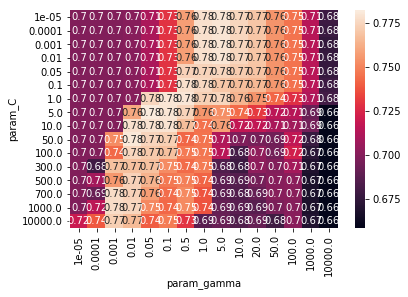

In [18]:
h=G[["param_C", "param_gamma", "mean_test_score"]].pivot_table(index="param_C", columns="param_gamma", values="mean_test_score")
sns.heatmap(h, annot=True)

Confusion matrix, without normalization
[[24 18]
 [ 2 92]]
Normalized confusion matrix
[[0.57 0.43]
 [0.02 0.98]]


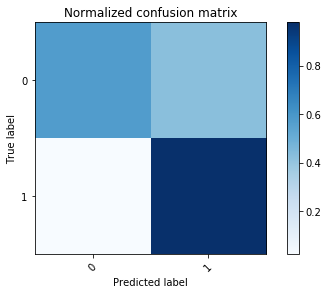

In [19]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names=["0", "1"]
    
# Compute confusion matrix
cm = confusion_matrix(y_test, grid_search.predict(X_test))
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)

# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, class_names, title='Normalized confusion matrix')

plt.show()

In [20]:
# Classification report:
report=classification_report(y_test, grid_search.predict(X_test))
print(report)

             precision    recall  f1-score   support

          0       0.92      0.57      0.71        42
          1       0.84      0.98      0.90        94

avg / total       0.86      0.85      0.84       136



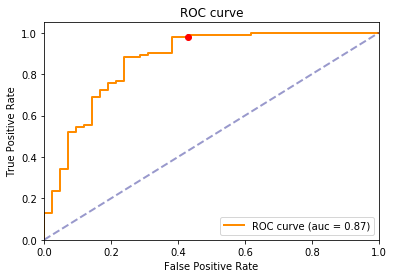

In [21]:
# ROC curve & auc:
from  sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, average_precision_score

fpr, tpr, thresholds=roc_curve(np.array(y_test), grid_search.decision_function(X_test) , pos_label=1)
roc_auc=roc_auc_score(np.array(y_test), grid_search.decision_function(X_test))

plt.figure()

plt.step(fpr, tpr, color='darkorange', lw=2, label='ROC curve (auc = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', alpha=0.4, lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

plt.plot([cm_normalized[0,1]], [cm_normalized[1,1]], 'or')
plt.show()

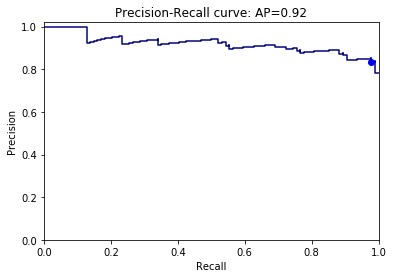

In [22]:
# Precision-Recall trade-off:
precision, recall, thresholds=precision_recall_curve(y_test,grid_search.predict_proba(np.array(X_test))[:, 1],  pos_label=1)
ave_precision=average_precision_score(y_test,grid_search.predict_proba(np.array(X_test))[:, 1])

plt.step(recall, precision, color='navy')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0, 1.001])
plt.ylim([0, 1.02])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(ave_precision))

plt.plot([cm_normalized[1,1]], [cm[1,1]/(cm[1,1]+cm[0,1])], 'ob')
plt.show()